In [1]:
import psycopg2
import os

In [2]:
import matplotlib.pyplot as plt
cm = 1/2.54

# set matplotlib size
def mpl_figsize(scale_factor: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor, 4.8 * scale_factor

def mpl_figsize_xy(scale_factor_x: int | float, scale_factor_y: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor_x, 4.8 * scale_factor_y

def group_bottom_percent(labels, sizes, threshold):
    total = sum(sizes)
    labels_filtered = []
    sizes_filtered = []
    count = 0
    other_count = 0
    for label, size in zip(labels, sizes):
        if size / total < threshold:
            count += 1
            other_count += size
        else:
            labels_filtered.append(label)
            sizes_filtered.append(size)
    labels_filtered.append(f'other ({count})')
    sizes_filtered.append(other_count)
    return labels_filtered, sizes_filtered

In [56]:
# setup connection
conn = psycopg2.connect(
    host='localhost',
    database='cadets_e3',
    user='rosendahl',
)
conn.set_session(readonly=True)
# get cursor
cur = conn.cursor()

insert_cursor = conn.cursor()

In [47]:
# debug
os.system("hostnamectl hostname")
print(f'current working directory: {os.getcwd()}')

vmrosendahl
current working directory: /home/rosendahl/remote_interpreter/dataset/jupyter


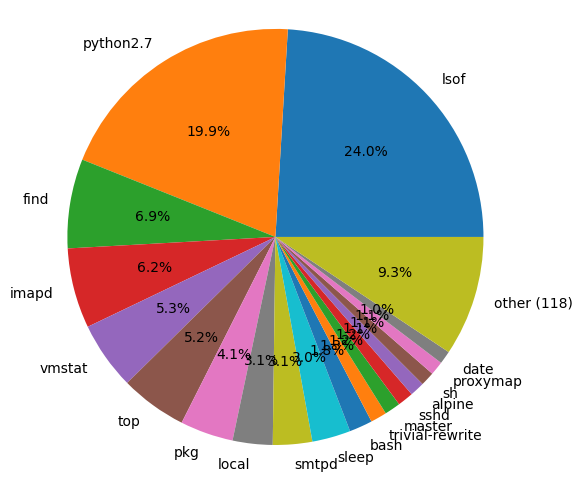

In [48]:
# visualize event distribution
query = '''
select distinct e.properties_map_exec, count(e.properties_map_exec) as count 
from event e 
group by e.properties_map_exec;
'''

cur.execute(query)
results_count_distinct_execs = cur.fetchall()

# plot exec distribution

# sort by count
results_count_distinct_execs.sort(key=lambda x: x[1], reverse=True)

labels = [row[0] for row in results_count_distinct_execs]
sizes = [row[1] for row in results_count_distinct_execs]

labels, sizes = group_bottom_percent(labels, sizes, 0.01)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'size': 'medium'})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# resize
fig.set_size_inches((15*cm, 15*cm))

plt.savefig('figures/executable_events_distribution.svg')
plt.show()

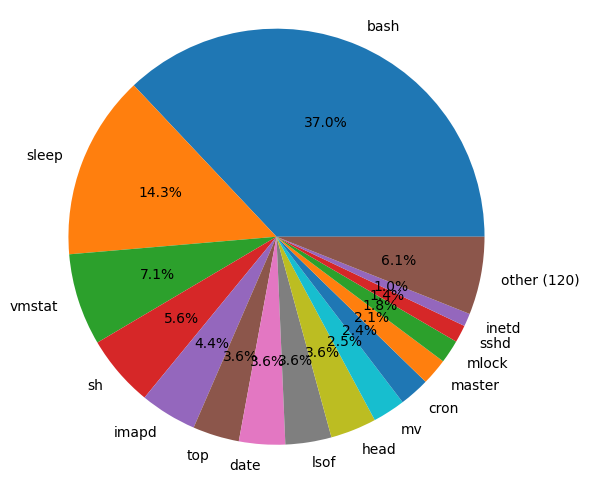

In [49]:
# visualize class distribution
query = '''
select executable, count(executable) as count
from sequence
group by executable
order by count desc;
'''

cur.execute(query)
result = cur.fetchall()

labels = [row[0] for row in result]
sizes = [row[1] for row in result]

labels, sizes = group_bottom_percent(labels, sizes, 0.01)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'size': 'medium'})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig.set_size_inches((15*cm, 15*cm))

plt.savefig('figures/class_distribution.svg')
plt.show()

In [50]:
# visualize class distribution with sliding window 
window_size = 1000
query = f'''
select executable, length
from sequence
'''

occurrence = {}

cur.execute(query)
for row in cur:
    executable, length = row
    
    if executable not in occurrence:
        occurrence[executable] = 0
        
    if length <= window_size:
        occurrence[executable] += 1
    else:
        occurrence[executable] += length // window_size + 1 if length % window_size != 0 else 0

# convert dict to list of tuples
occurrence = [(k, v) for k, v in occurrence.items()]

bottom 10 labels:
touch: 1
chown: 1
chmod: 1
nice: 1
lsvfs: 1
main: 1
ssh: 1
locale: 1
whoami: 1
vUgefal: 1


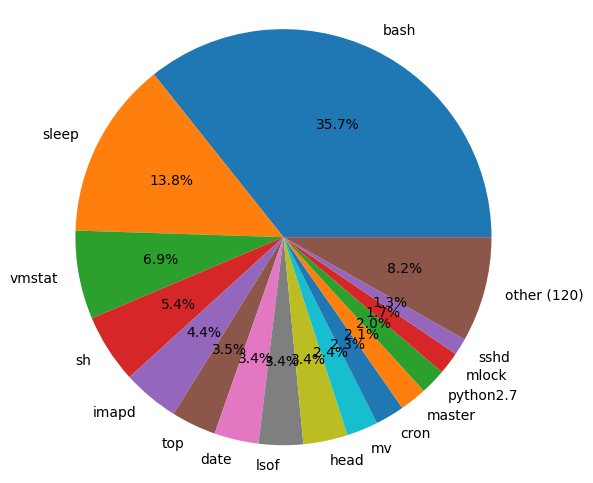

In [51]:
# sort by count
occurrence.sort(key=lambda x: x[1], reverse=True)


labels = [row[0] for row in occurrence]
sizes = [row[1] for row in occurrence]

# print bottom 10 labels with their sizes
print('bottom 10 labels:')
for label, size in zip(labels[-10:], sizes[-10:]):
    print(f'{label}: {size}')

labels, sizes = group_bottom_percent(labels, sizes, 0.01)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'size': 'medium'})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig.set_size_inches((15*cm, 15*cm))

plt.savefig(f'figures/class_distribution_windowed_{window_size}.svg')
plt.show()

[('EVENT_EXIT', 215741),
 ('EVENT_EXECUTE', 207747),
 ('EVENT_UNLINK', 7374),
 ('EVENT_SIGNAL', 360),
 ('EVENT_CLOSE', 233),
 ('EVENT_FORK', 160),
 ('EVENT_READ', 69),
 ('EVENT_WRITE', 59),
 ('EVENT_OPEN', 48),
 ('EVENT_SENDTO', 24),
 ('EVENT_MMAP', 22),
 ('EVENT_FCNTL', 22),
 ('EVENT_MODIFY_PROCESS', 12),
 ('EVENT_LSEEK', 10),
 ('EVENT_RECVFROM', 6),
 ('EVENT_CHANGE_PRINCIPAL', 3),
 ('EVENT_SENDMSG', 2),
 ('EVENT_RECVMSG', 2),
 ('EVENT_CREATE_OBJECT', 1)]

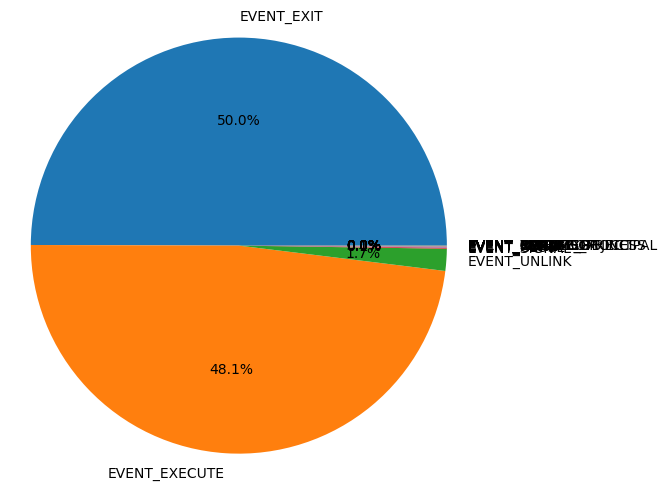

In [52]:
# how do sequences in processes look like?
# 1. what are the last events in sequences? -> iterate over all sequences and get the last event
sequence_dir = f'{os.getcwd()}/data/sequences_export'

list_files = os.listdir(sequence_dir)
last_events = {}

for file in list_files:
    with open(f'{sequence_dir}/{file}', 'r') as f:
        last_event = f.readlines()[-1].strip()
        if last_event not in last_events:
            last_events[last_event] = 0
        last_events[last_event] += 1

# convert dict to list of tuples
last_events = [(k, v) for k, v in last_events.items()]

# sort by count
last_events.sort(key=lambda x: x[1], reverse=True)

display(last_events)

labels = [row[0] for row in last_events]
sizes = [row[1] for row in last_events]

# labels, sizes = group_bottom_percent(labels, sizes, 0.01)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'size': 'medium'})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig.set_size_inches((15*cm, 15*cm))

# plt.savefig('figures/last_events_distribution.svg')
plt.show()

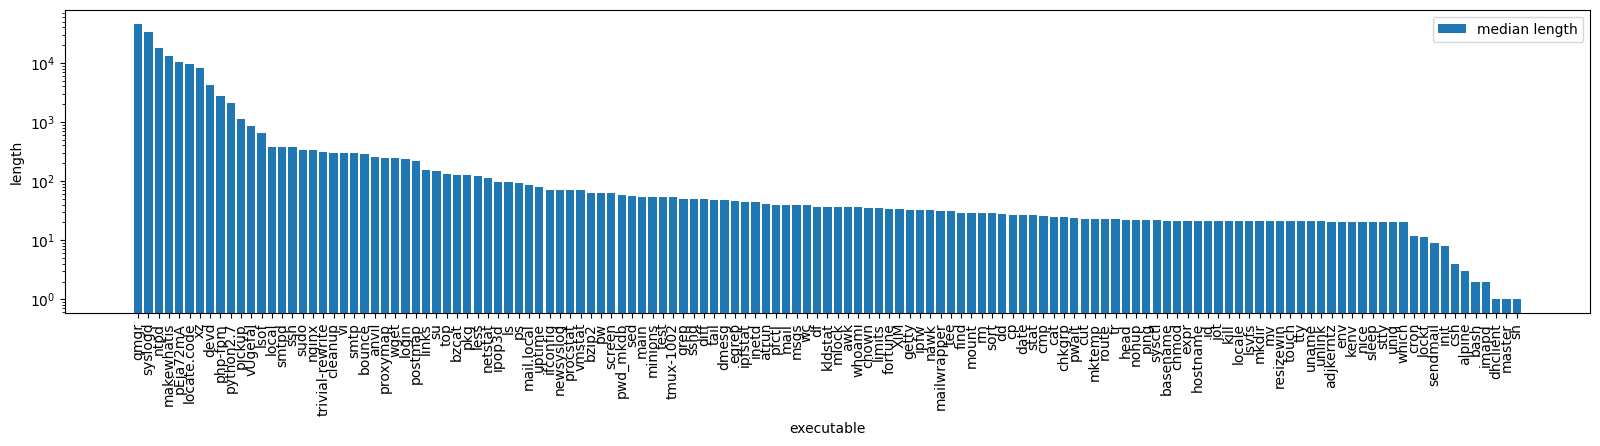

In [66]:
# 2. sequence lengths by executable
query = '''
select executable, avg(length), max(length), min(length), stddev(length), percentile_cont(0.5) within group (order by length) as median
from sequence
group by executable
'''

cur.execute(query)
result = cur.fetchall()

# sort by median length
result.sort(key=lambda x: x[5], reverse=True)

# unpack result
executables = [row[0] for row in result]
avg_lengths = [row[1] for row in result]
max_lengths = [row[2] for row in result]
min_lengths = [row[3] for row in result]
stddev_lengths = [row[4] for row in result]
median_lengths = [row[5] for row in result]


fig, ax = plt.subplots()
#ax.bar(executables, avg_lengths, label='average length')
#ax.bar(executables, max_lengths, label='max length')
#ax.bar(executables, min_lengths, label='min length')
#ax.bar(executables, stddev_lengths, label='stddev length')
ax.bar(executables, median_lengths, label='median length')

ax.set_xlabel('executable')
ax.set_ylabel('length')
ax.legend()

# y axis log scale
ax.set_yscale('log')

# x axis labels rotate
plt.xticks(rotation=90)

fig.set_size_inches((50*cm, 10*cm))

plt.savefig('figures/sequence_length_by_executable.svg')

plt.show()

In [64]:
# statistics for sequence lengths for all executables
query = '''
select avg(length), max(length), min(length), stddev(length), percentile_cont(0.5) within group (order by length) as median
from sequence
'''

cur.execute(query)
result = cur.fetchall()

avg_length, max_length, min_length, stddev_length, median_length = result[0]

print(f'avg length: {avg_length}')
print(f'max length: {max_length}')
print(f'min length: {min_length}')
print(f'stddev length: {stddev_length}')
print(f'median length: {median_length}')

avg length: 95.6039523495293995
max length: 3049408
min length: 1
stddev length: 6237.841597713132
median length: 20.0


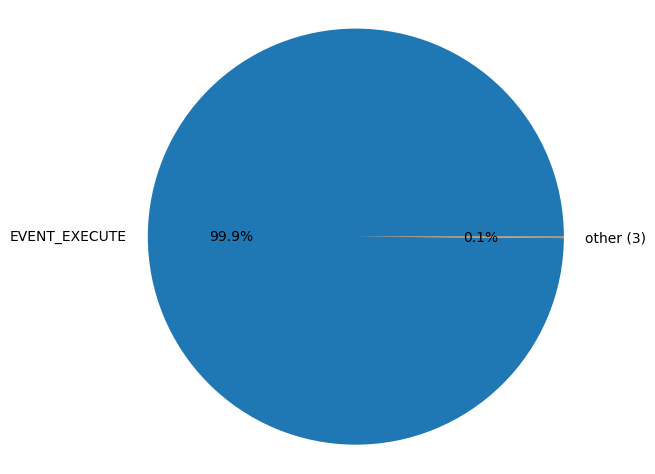

In [74]:
# dhclient, sh, master have median 1 Event. plot distribution of events for these executables

file_list = os.listdir(sequence_dir)

event_types = {}

for file in file_list:
    file_name = file[0:-len('.txt')]
    if file_name.count('_') == 2:
        executable, subject_uuid, no = file_name.split('_')
    elif file.count('_') == 3:
        # pwd_mkdb
        executable, tmp, subject_uuid, no = file_name.split('_')
        executable += '_' + tmp
    else:
        print(f'Error: {file_name}')
        continue
    
    if executable not in ['dhclient', 'sh', 'master']:
        continue
    with open(f'{sequence_dir}/{file}', 'r') as f:
        # get length of file
        lines = f.readlines()
        if len(lines) > 1:
            continue
        for line in lines:
            event_type = line.strip()
            if event_type not in event_types:
                event_types[event_type] = 0
            event_types[event_type] += 1

# plot 
event_types = [(k, v) for k, v in event_types.items()]

# sort by count
event_types.sort(key=lambda x: x[1], reverse=True)

labels = [row[0] for row in event_types]
sizes = [row[1] for row in event_types]

labels, sizes = group_bottom_percent(labels, sizes, 0.01)

fig, ax = plt.subplots()

ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'size': 'medium'})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig.set_size_inches((15*cm, 15*cm))

plt.savefig('figures/event_distribution_dhclient_sh_master.svg')
plt.show()

In [16]:
# get info about predicate object 1 path

sequence_dir = f'{os.getcwd()}/data/sequences_export_path1'

abs_count = 0
rel_count = 0

list_files = os.listdir(sequence_dir)
top_tldirectories = {}
top_files = {}

for file in list_files:
    with open(f'{sequence_dir}/{file}', 'r') as f:
        for line in f:
            line = line.strip()
            # get string starting from first ','
            line = line[line.find(',')+1:]
            if line == 'None':
                continue
            tokens = line.split('/')
            
            if tokens[0] == '' or tokens[0] == '.' or tokens[0] == '..':
                # absolute path
                abs_count += 1
                if tokens[1] not in top_tldirectories:
                    top_tldirectories[tokens[1]] = 0
                top_tldirectories[tokens[1]] += 1
                filename = tokens[-1]
            else:
                # relative path
                rel_count += 1
                filename = tokens[-1]
            if filename not in top_files:
                top_files[filename] = 0
            top_files[filename] += 1

top 10 tldirectories:
dev: 6521747
etc: 4246592
usr: 2779829
var: 1173909
lib: 562427
data: 389648
home: 384366
bin: 98279
tmp: 41741
root: 5183

top 10 files:
kmem: 4169304
<unknown>: 2124502
random: 1614084
pwd.db: 1475877
spwd.db: 635033
ld-elf.so.hints: 631639
services: 631083
..: 476598
libmap.conf: 420705
tty: 412467

amount of different tldirectories: 51
amount of different files: 125652

absolute paths: 16208638
relative paths: 2302600


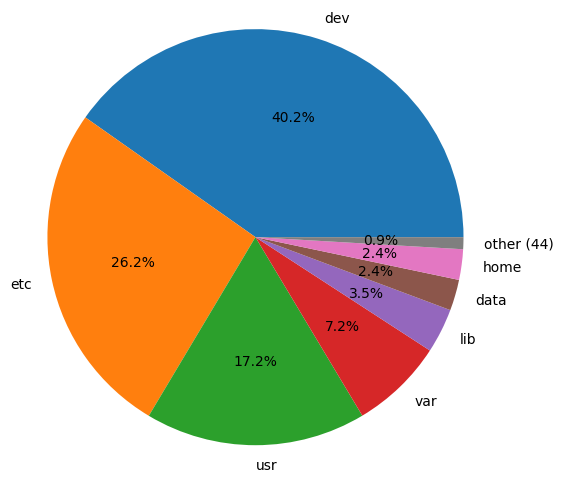

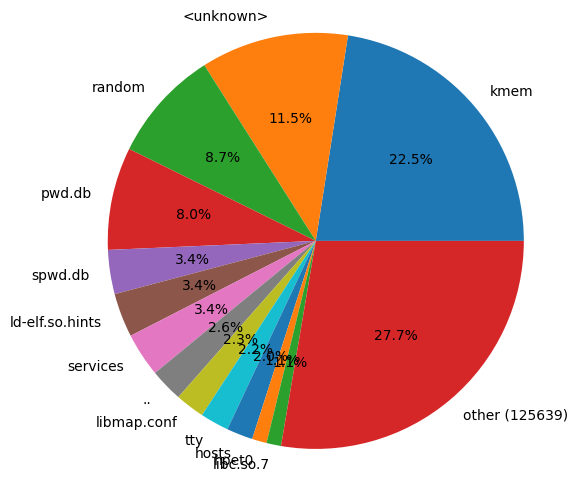

In [19]:
# sort by count
top_tldirectories_list = [(k, v) for k, v in top_tldirectories.items()]
top_files_list = [(k, v) for k, v in top_files.items()]

top_tldirectories_list.sort(key=lambda x: x[1], reverse=True)

top_files_list.sort(key=lambda x: x[1], reverse=True)

# print top 10 tldirectories
print('top 10 tldirectories:')
for tldirectory, count in top_tldirectories_list[:10]:
    print(f'{tldirectory}: {count}')

print()
# print top 10 files
print('top 10 files:')
for file, count in top_files_list[:10]:
    print(f'{file}: {count}')

print()
print(f'amount of different tldirectories: {len(top_tldirectories_list)}')
print(f'amount of different files: {len(top_files_list)}')

print()
print(f'absolute paths: {abs_count}')
print(f'relative paths: {rel_count}')

# pie plot for tldirectories
labels = [row[0] for row in top_tldirectories_list]
sizes = [row[1] for row in top_tldirectories_list]

labels, sizes = group_bottom_percent(labels, sizes, 0.01)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'size': 'medium'})

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig.set_size_inches((15*cm, 15*cm))

plt.show()

# pie plot for files
labels = [row[0] for row in top_files_list]
sizes = [row[1] for row in top_files_list]

labels, sizes = group_bottom_percent(labels, sizes, 0.01)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'size': 'medium'})

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig.set_size_inches((15*cm, 15*cm))

plt.show()


In [54]:
# destroy cursor and connection
cur.close()
conn.close()